In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from nn_tools.model_builder import Network
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

MODEL_SEED = 2824180  # chosen by keyboard-mashing
DATA_SEED = MODEL_SEED + 10

data = tv.datasets.CIFAR10('data/cifar10',
                           train=True,
                           transform=tv.transforms.ToTensor())
loader = torch.utils.data.DataLoader(data,
                                     batch_size=128,
                                     shuffle=True,
                                     generator=torch.Generator().manual_seed(DATA_SEED),
                                     pin_memory=True,
                                     num_workers=16)

# Get a single example batch for testing
im, la = next(iter(loader))

## Define a convnet the old-fashioned way

In [6]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.bn1 = nn.BatchNorm2d(num_features=3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(4)

        self.proj = nn.Linear(256, 10)

    def forward(self, x):
        # 3x32x32 --> 32x16x16
        h1 = self.pool1(F.relu(self.conv1(self.bn1(x))))
        # 32x16x16 --> 64x8x8
        h2 = self.pool2(F.relu(self.conv2(self.bn2(h1))))
        # 64x8x8 --> 128x4x4
        h3 = self.pool3(F.relu(self.conv3(self.bn3(h2))))
        # 128x4x4 --> 256x1x1
        h4 = self.pool4(F.relu(self.conv4(self.bn4(h3))))
        return self.proj(h4.view(-1, 256))

Inspect its output

In [7]:
torch.manual_seed(MODEL_SEED)
mdl1 = MyConvNet()
out1 = mdl1(im)

print("Output from mdl1 is")
pprint(out1)

Output from mdl1 is
tensor([[ 0.1270, -0.4351,  0.2332,  ..., -0.3311,  0.8854,  0.1848],
        [-0.1037,  0.0427,  0.4922,  ..., -0.5694,  1.0838,  0.4452],
        [ 0.2170, -0.1277,  0.0483,  ..., -0.4353,  0.7047,  0.4597],
        ...,
        [-0.7034, -0.1524, -0.0270,  ..., -0.3770,  0.9031,  0.4068],
        [-0.3043, -0.3115, -0.2036,  ..., -0.2595,  0.4356,  0.3649],
        [ 0.1139, -0.3354,  0.0348,  ..., -0.3632,  0.7053,  0.1654]],
       grad_fn=<AddmmBackward0>)


## Define the same convnet using this fancy dict-parsing tool

In [8]:
def get_model_def():
    return {
        'input': None,
        'stack1': {
            'bn': nn.BatchNorm2d(num_features=3),
            'conv': nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(2)
        },
        'stack2': {
            'bn': nn.BatchNorm2d(num_features=32),
            'conv': nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(2)
        },
        'stack3': {
            'bn': nn.BatchNorm2d(num_features=64),
            'conv': nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(2)
        },
        'stack4': {
            'bn': nn.BatchNorm2d(num_features=128),
            'conv': nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(4)
        },
        'proj': nn.Sequential(nn.Flatten(), nn.Linear(256, 10))
    }

Create a model and inspect its output – now a dict of outputs!

In [9]:
torch.manual_seed(MODEL_SEED)
mdl2 = Network(get_model_def())
# out2 = mdl2(im)
out2 = mdl2({'input': im})

print("Output sizes from mdl2 are")
pprint({k: v.size() for k, v in out2.items()})
print("Outputs from mdl2 are")
pprint(out2)

Output sizes from mdl2 are
{'input': torch.Size([128, 3, 32, 32]),
 'proj': torch.Size([128, 10]),
 'stack1/bn': torch.Size([128, 3, 32, 32]),
 'stack1/conv': torch.Size([128, 32, 32, 32]),
 'stack1/pool': torch.Size([128, 32, 16, 16]),
 'stack1/relu': torch.Size([128, 32, 32, 32]),
 'stack2/bn': torch.Size([128, 32, 16, 16]),
 'stack2/conv': torch.Size([128, 64, 16, 16]),
 'stack2/pool': torch.Size([128, 64, 8, 8]),
 'stack2/relu': torch.Size([128, 64, 16, 16]),
 'stack3/bn': torch.Size([128, 64, 8, 8]),
 'stack3/conv': torch.Size([128, 128, 8, 8]),
 'stack3/pool': torch.Size([128, 128, 4, 4]),
 'stack3/relu': torch.Size([128, 128, 8, 8]),
 'stack4/bn': torch.Size([128, 128, 4, 4]),
 'stack4/conv': torch.Size([128, 256, 4, 4]),
 'stack4/pool': torch.Size([128, 256, 1, 1]),
 'stack4/relu': torch.Size([128, 256, 4, 4])}
Outputs from mdl2 are
{'input': tensor([[[[0.4275, 0.4627, 0.5137,  ..., 0.2863, 0.2902, 0.2941],
          [0.4235, 0.4314, 0.4941,  ..., 0.2902, 0.2863, 0.2941],
     

 'stack2/pool': tensor([[[[0.1992, 0.2361, 0.0000,  ..., 0.0000, 0.0000, 0.1714],
          [0.1180, 0.4843, 0.2495,  ..., 0.0000, 0.0000, 0.0488],
          [0.2693, 0.2910, 0.1349,  ..., 0.0865, 0.0793, 0.1813],
          ...,
          [0.0000, 0.0000, 0.0441,  ..., 0.7400, 0.7950, 0.9114],
          [0.0000, 0.0280, 0.0000,  ..., 0.7507, 0.9716, 0.7110],
          [0.2253, 0.2675, 0.3778,  ..., 0.2954, 0.2685, 0.0985]],

         [[0.4568, 0.2738, 0.4802,  ..., 0.2555, 0.2539, 0.0775],
          [0.2396, 0.2411, 0.5256,  ..., 0.5761, 0.2532, 0.1161],
          [0.3422, 0.3747, 0.4810,  ..., 1.0494, 0.9519, 0.1149],
          ...,
          [0.4766, 0.2388, 0.5419,  ..., 0.0627, 0.2011, 0.6339],
          [0.4835, 0.2599, 0.3508,  ..., 0.3906, 0.2078, 0.1793],
          [0.6420, 0.5162, 0.5569,  ..., 0.8609, 0.5452, 0.1975]],

         [[0.1195, 0.0000, 0.1195,  ..., 0.2847, 0.3095, 0.5143],
          [0.0000, 0.0000, 0.4641,  ..., 0.3153, 0.2761, 0.5076],
          [0.0000, 0.0000,

Are the outputs from mdl1 and mdl2 the same?

In [10]:
torch.allclose(out1, out2['proj'])

True

## Cool thing we can now do #1: inspecting hidden unit activity at any point in the network

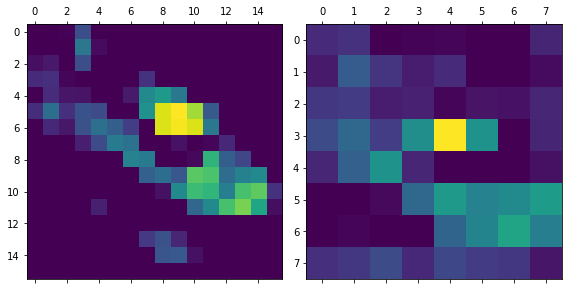

In [11]:
fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].matshow(out2['stack1/pool'].detach().cpu()[0,0,...])
ax[1].matshow(out2['stack2/pool'].detach().cpu()[0,0,...])
fig.tight_layout()

## Cool thing we can now do #2: running the network forward starting at a hidden layer

In [13]:
orig_stack1 = out2['stack1/pool'].detach()
jittered_out2 = mdl2({'stack1/pool': orig_stack1 + torch.randn(orig_stack1.size())*.1}, warn_if_missing=False)

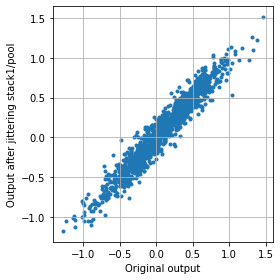

In [14]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(out2['proj'].detach().cpu(),
           jittered_out2['proj'].detach().cpu(),
           marker='.')
ax.set_xlabel('Original output')
ax.set_ylabel('Output after jittering stack1/pool')
ax.grid('on')
fig.tight_layout()

## But wait – isn't it expensive to store all activations of all layers in a dict?

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

mdl1.to(device)
mdl2.to(device)

print("Using", device)

Using cuda:0


In [16]:
def train_epoch(model, opt, loader, device):
    model.train()
    for im, la in tqdm(loader, desc='Batches', total=len(loader)):
        im, la = im.to(device), la.to(device)
        opt.zero_grad()
        out = mdl1(im)
        loss = F.cross_entropy(out, la)
        loss.backward()
        opt.step()

### Profile running a single training epoch for the old-fashioned model

In [19]:
opt = torch.optim.Adam(mdl1.parameters(), lr=1e-3)
%time train_epoch(mdl1, opt, loader, device)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Exception ignored in: IOStream.flush timed out
IOStream.flush timed out


Batches:   0%|          | 0/391 [01:40<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f086a8dd7e0>
Traceback (most recent call last):
  File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f086a8dd7e0>    if w.is_alive():
  File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f086a8dd7e0>: 
Traceback (most recent call last):
can only test a child processException ignored in:   File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/site-packages/torch/utils/data/dataloader.

assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers():   File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    
can only test a child process    
if w.is_alive():AssertionError
    if w.is_alive():  File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

:     if w.is_alive():
        can only test a child process
  File "/home/rlange/anaconda3/envs/modularity/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():if w.is_alive(

CPU times: user 10.2 s, sys: 2.84 s, total: 13 s
Wall time: 1min 45s


### Profile a single training epoch using the fancy model

In [20]:
opt = torch.optim.Adam(mdl2.parameters(), lr=1e-3)
%time train_epoch(mdl2, opt, loader, device)

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

CPU times: user 8.95 s, sys: 2.35 s, total: 11.3 s
Wall time: 4.1 s
